In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import plotly.express as px
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/temperature_device_failure.csv', index_col=0, parse_dates=True)

# Data Visualization


In [ ]:
#summarize data
def summary(df):
    print(df)
    print('Info:')
    print(df.info())
    print('Shape:', df.shape)
    print('Summary Statistics:')
    print(df.describe())
    print(df.isnull().sum())

summary(df)

                         value
timestamp                     
2013-07-04 00:00:00  69.880835
2013-07-04 01:00:00  71.220227
2013-07-04 02:00:00  70.877805
2013-07-04 03:00:00  68.959400
2013-07-04 04:00:00  69.283551
...                        ...
2014-05-28 11:00:00  72.370206
2014-05-28 12:00:00  72.172956
2014-05-28 13:00:00  72.046565
2014-05-28 14:00:00  71.825226
2014-05-28 15:00:00  72.584089

[7267 rows x 1 columns]
Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7267 entries, 2013-07-04 00:00:00 to 2014-05-28 15:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   7267 non-null   float64
dtypes: float64(1)
memory usage: 113.5 KB
None
Shape: (7267, 1)
Summary Statistics:
             value
count  7267.000000
mean     71.242433
std       4.247509
min      57.458406
25%      68.369411
50%      71.858493
75%      74.430958
max      86.223213
value    0
dtype: int64


In [ ]:
#plot data using plotly express library
fig = px.line(df, y='value', title='Time Series Plot of Temperature', labels={'timestamp': 'Timestamp', 'value': 'Temperature'})
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

# Feature Engineering

In [ ]:
#create day of week and hour features
df['dayofweek']=df.index.dayofweek
df['hour']=df.index.hour

In [ ]:
#define function to categorize datetime by using above variables
from numpy.lib import row_stack
def categorize_datetime(row):
    if row['dayofweek'] < 5:  # Weekdays (Monday to Friday)
        if 7 <= row['hour'] <= 18:  # Daytime: 7:00 am - 7:00 pm
            return 'Weekday Day'
        else:  # Nighttime
            return 'Weekday Night'
    else:  # Weekends (Saturday and Sunday)
        if 7 <= row['hour'] <= 18:  # Daytime: 7:00 am - 7:00 pm
            return 'Weekend Day'
        else:  # Nighttime
            return 'Weekend Night'


In [ ]:
#create date-time-category variable by applying function
df['dtcat'] = df.apply(categorize_datetime, axis=1)

In [ ]:
df

,value,dayofweek,hour,dtcat
timestamp,,,,
2013-07-04 00:00:00,69.880835,3,0,Weekday Night
2013-07-04 01:00:00,71.220227,3,1,Weekday Night
2013-07-04 02:00:00,70.877805,3,2,Weekday Night
2013-07-04 03:00:00,68.959400,3,3,Weekday Night
2013-07-04 04:00:00,69.283551,3,4,Weekday Night
...,...,...,...,...
2014-05-28 11:00:00,72.370206,2,11,Weekday Day
2014-05-28 12:00:00,72.172956,2,12,Weekday Day
2014-05-28 13:00:00,72.046565,2,13,Weekday Day


In [ ]:
# convert to numeric form for analysis
df['dtcat'] = df['dtcat'].map({'Weekday Day': 0, 'Weekday Night': 1, 'Weekend Day': 2, 'Weekend Night': 3})

In [ ]:
df

,value,dayofweek,hour,dtcat
timestamp,,,,
2013-07-04 00:00:00,69.880835,3,0,1
2013-07-04 01:00:00,71.220227,3,1,1
2013-07-04 02:00:00,70.877805,3,2,1
2013-07-04 03:00:00,68.959400,3,3,1
2013-07-04 04:00:00,69.283551,3,4,1
...,...,...,...,...
2014-05-28 11:00:00,72.370206,2,11,0
2014-05-28 12:00:00,72.172956,2,12,0
2014-05-28 13:00:00,72.046565,2,13,0


# KMeans Clustering

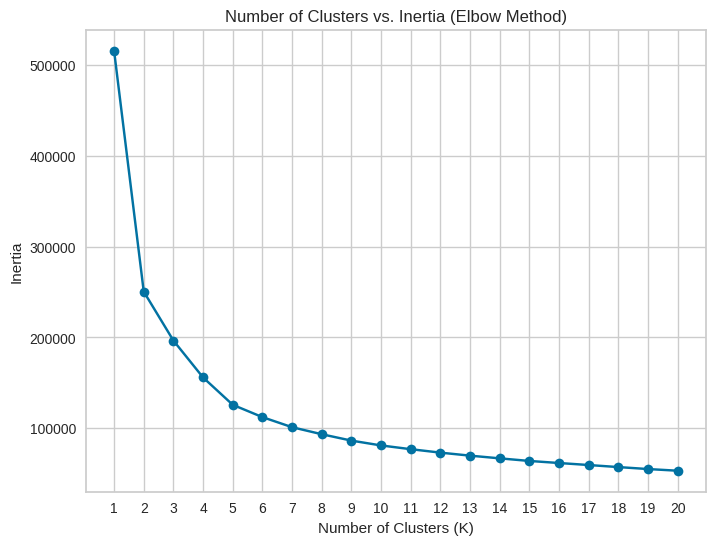

In [ ]:
#using inertia to find optimal number of clusters for kmeans

from sklearn.cluster import KMeans
k_values = range(1,21)
inertia = []

X = df[['value', 'dayofweek', 'hour', 'dtcat']]

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)

# Plot the number of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.title('Number of Clusters vs. Inertia (Elbow Method)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()


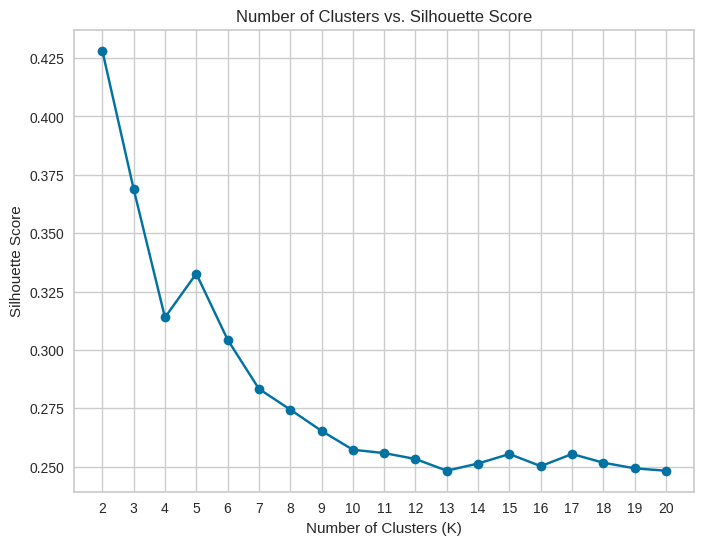

In [ ]:
#using Silhouette -- (b-a) / max(a,b)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 21)

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the number of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Number of Clusters vs. Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

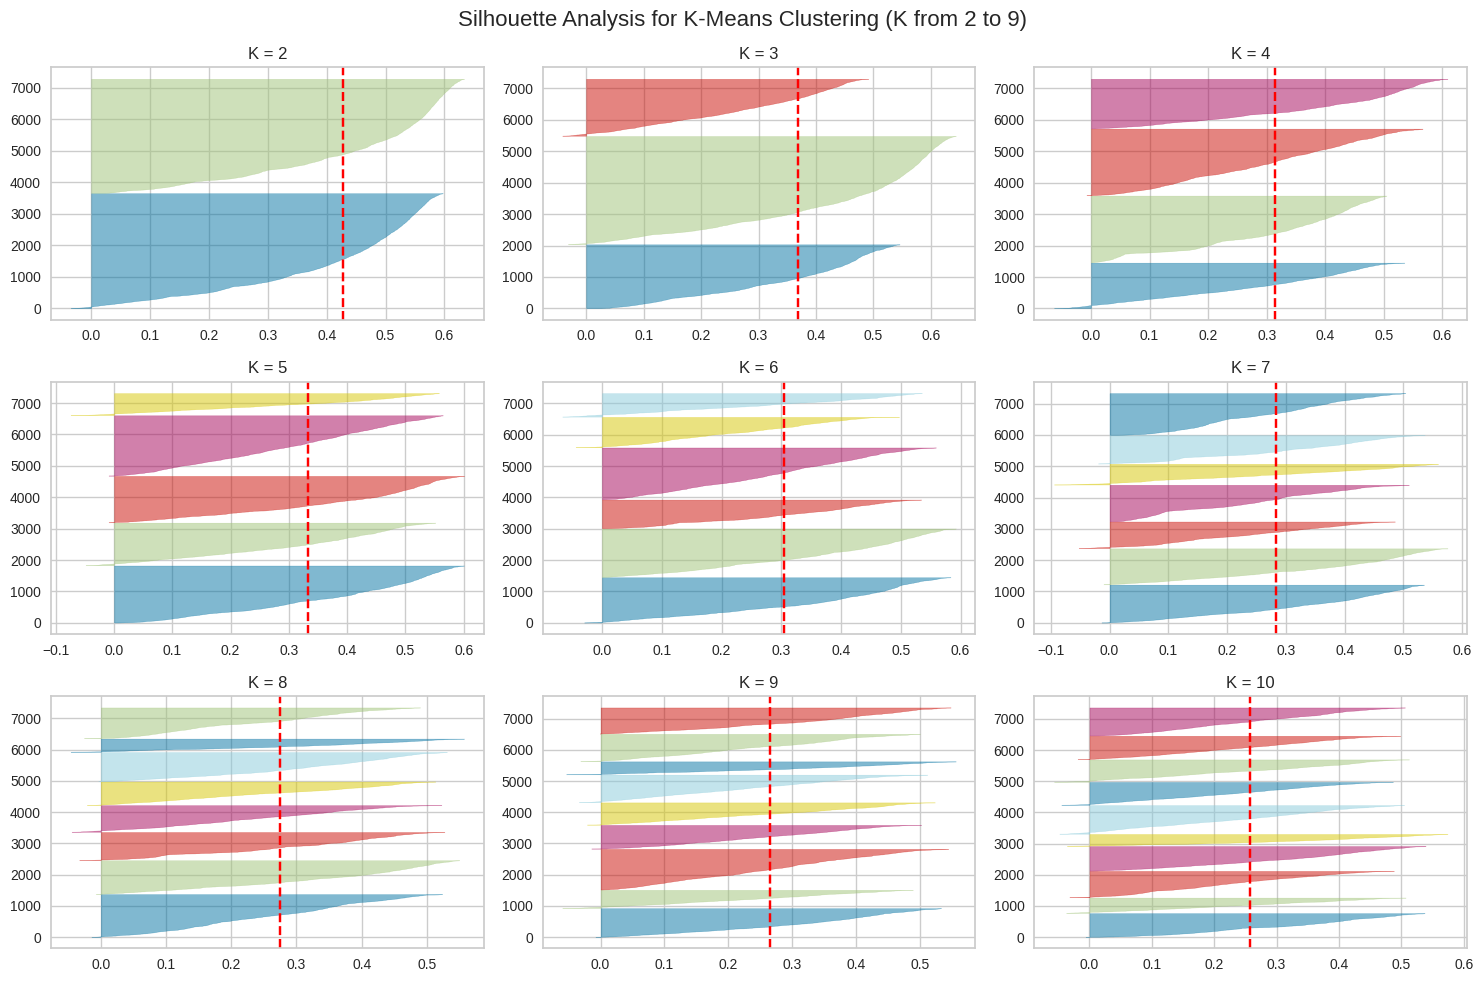

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_values = range(2, 11)

num_rows = 3
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, k in enumerate(k_values):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    row, col = divmod(i, num_cols)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[row, col])
    visualizer.fit(X)

    ax[row, col].set_title(f'K = {k}')

plt.suptitle("Silhouette Analysis for K-Means Clustering (K from 2 to 9)", fontsize=16)
plt.tight_layout()
plt.show()


# PCA

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



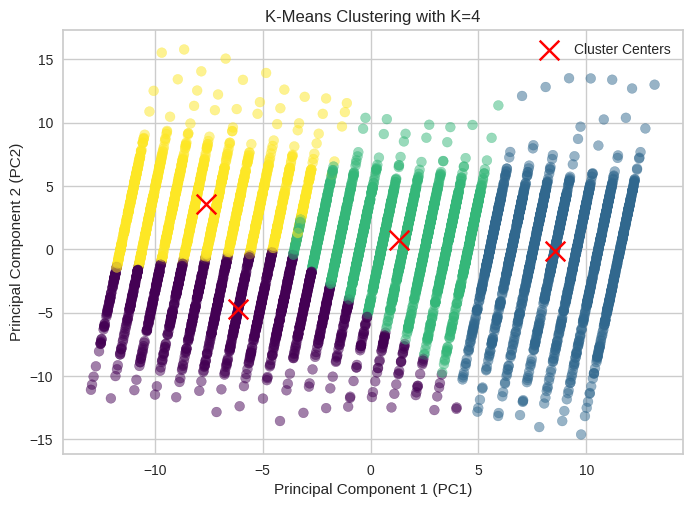

In [ ]:
#applying kmeans with best k value
from sklearn.decomposition import PCA

best_k1 = 4

kmeans = KMeans(n_clusters=best_k1, init='k-means++', n_init=10, max_iter=100, random_state=42)

kmeans.fit(X)

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

#cluster centers
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

#plot
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5, s=50)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='x', s=200, label='Cluster Centers')

plt.title(f"K-Means Clustering with K={best_k1}")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



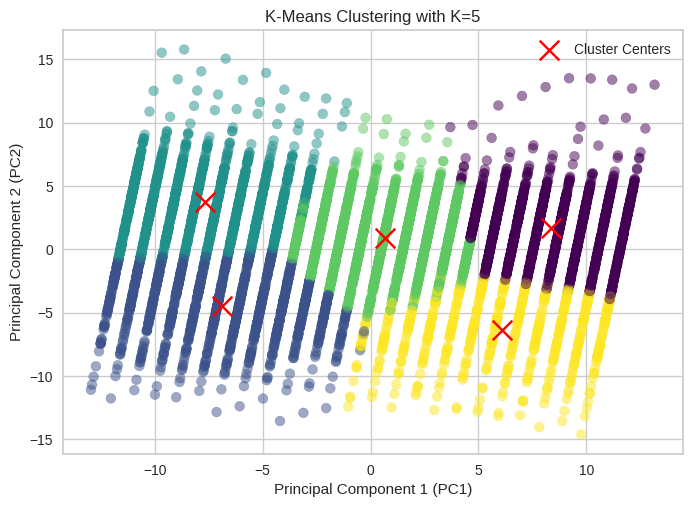

In [ ]:
from sklearn.decomposition import PCA

best_k2 = 5

kmeans = KMeans(n_clusters=best_k2, init='k-means++', n_init=10, max_iter=100, random_state=42)

kmeans.fit(X)

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

#plot with cluster centers
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5, s=50)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='x', s=200, label='Cluster Centers')

plt.title(f"K-Means Clustering with K={best_k2}")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



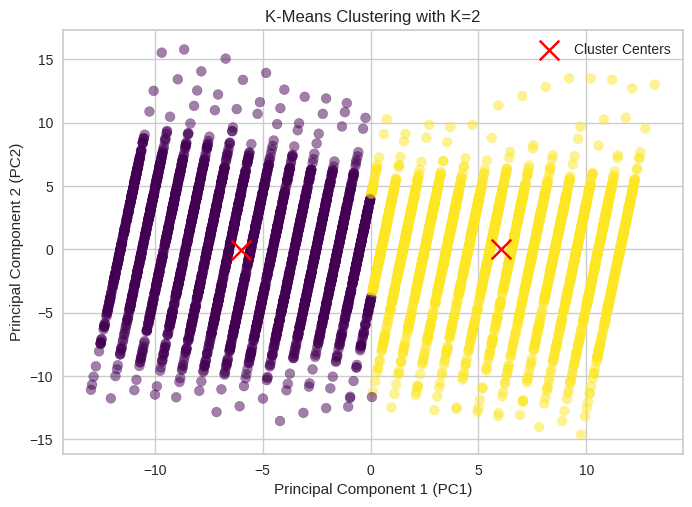

In [ ]:
from sklearn.decomposition import PCA

best_k3 = 2

kmeans = KMeans(n_clusters=best_k3, init='k-means++', n_init=10, max_iter=100, random_state=42)

kmeans.fit(X)

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

#plot with cluster centers
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5, s=50)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='x', s=200, label='Cluster Centers')

plt.title(f"K-Means Clustering with K={best_k3}")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend()
plt.show()

# Outliers


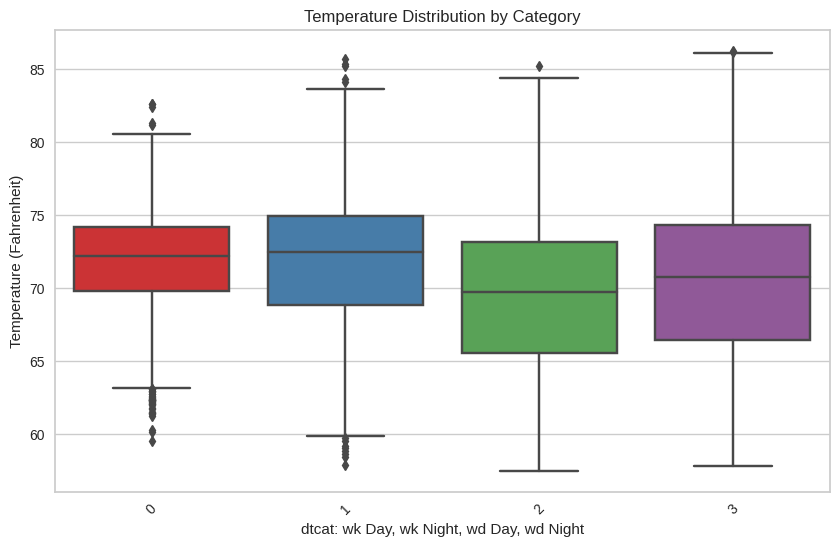

In [ ]:
#visualize the distribution of temperature values across the time categories
data = df[['value', 'dtcat']]

plt.figure(figsize=(10, 6))
sns.boxplot(x='dtcat', y='value', data=df, palette="Set1")
plt.title("Temperature Distribution by Category")
plt.xlabel("dtcat: wk Day, wk Night, wd Day, wd Night")
plt.ylabel("Temperature (Fahrenheit)")
plt.xticks(rotation=45)

plt.show()


The median values during the weekday are slightly higher than the weekend, and they seem to have more outliers within their respective categories. During the weekend, it seems there are larger temperature ranges, dropping below 58 and and going above 84 degrees. This might suggest different patterns for weekday vs weekend.

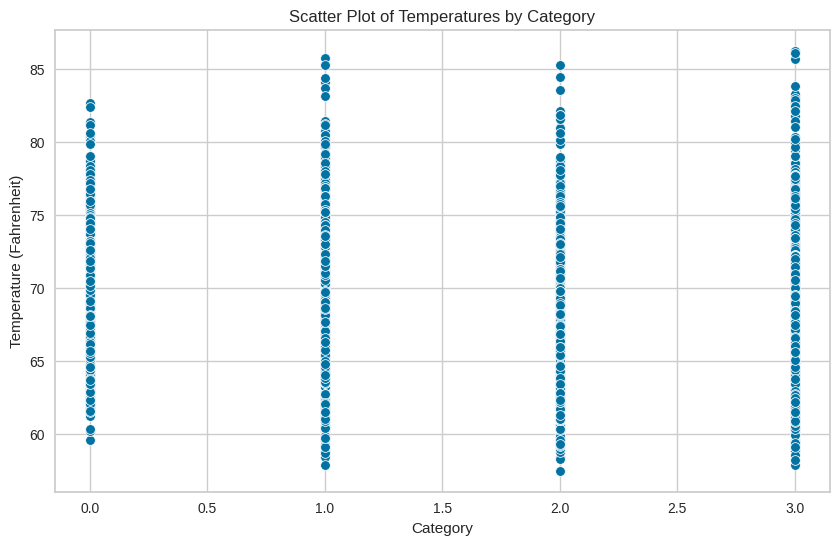

In [ ]:
#additional scatterplot of temperatures by category
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dtcat', y='value', data=data)
plt.title("Scatter Plot of Temperatures by Category")
plt.xlabel("Category")
plt.ylabel("Temperature (Fahrenheit)")
plt.show()

In [ ]:
#set given outliers fraction -- expecting 1% of values to be outliers
outliers_fraction = 0.01

total_data = len(df)
total_outliers = round(outliers_fraction * len(df))

print(f'The total number of outliers with 0.01 fraction is: {total_outliers}')

The total number of outliers with 0.01 fraction is: 73


In [ ]:
#calculate outliers fraction using IQR method based on values
from functools import total_ordering
Q1 = df['value'].quantile(0.25)
Q2 = df['value'].quantile(0.50)
Q3 = df['value'].quantile(0.75)

print('Q1:', Q1)
print('Q2:', Q2)
print('Q3:', Q3)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('The lower bound is:', lower_bound)
print('The upper bound is:', upper_bound)

count_below = 0
count_above = 0

for value in df['value']:
  if value < lower_bound:
    count_below +=1
  elif value > upper_bound:
    count_above +=1

print("Data points below lower bound:", count_below)
print("Data points above upper bound:", count_above)

total_outliers = count_above + count_below
total_data = len(df)
print('The total number of outliers utilizing the IQR method is:', total_outliers)

outliers_fraction1 = total_outliers / total_data
print('The calculated outliers fraction is:', outliers_fraction1) #expecting 0.4% of values to be outliers

Q1: 68.36941051
Q2: 71.85849263
Q3: 74.43095786
The lower bound is: 59.277089484999976
The upper bound is: 83.52327888500002
Data points below lower bound: 21
Data points above upper bound: 14
The total number of outliers utilizing the IQR method is: 35
The calculated outliers fraction is: 0.004816292830604101


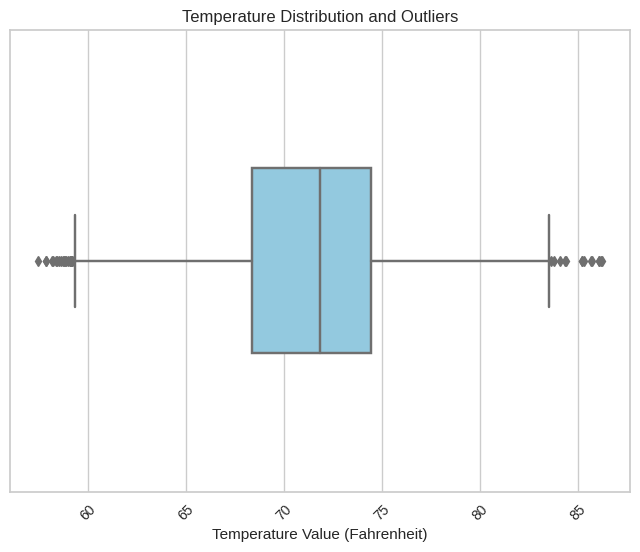

In [ ]:
#visualize outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x='value', data=df, color='skyblue', width=0.4)
plt.title("Temperature Distribution and Outliers")
plt.xlabel("Temperature Value (Fahrenheit)")
plt.xticks(rotation=45)
plt.show()

# Gaussian Distribution

In [ ]:
#GD model given 0.01 as outliers_fraction
from sklearn.covariance import EllipticEnvelope

gdmodel = EllipticEnvelope(contamination=outliers_fraction, random_state=42)
gdmodel.fit(data)
gdmodel_pred = gdmodel.predict(data)

gdoutliers = data[gdmodel_pred == -1]
count_outliers = gdoutliers.shape[0]
print('The count of outliers is:', count_outliers)

#outliers by dt category
outliers_by_category = gdoutliers.groupby('dtcat').size().reset_index(name='count')
print(outliers_by_category)

print(gdoutliers)

The count of outliers is: 73
   dtcat  count
0      2      3
1      3     70
                         value  dtcat
timestamp                            
2013-12-21 22:00:00  83.247886      3
2013-12-22 01:00:00  83.780995      3
2013-12-22 19:00:00  86.094888      3
2013-12-22 20:00:00  86.204189      3
2013-12-22 21:00:00  86.223213      3
...                        ...    ...
2014-05-25 19:00:00  61.046600      3
2014-05-25 20:00:00  62.456153      3
2014-05-25 21:00:00  60.847654      3
2014-05-25 22:00:00  62.162018      3
2014-05-25 23:00:00  61.472443      3

[73 rows x 2 columns]


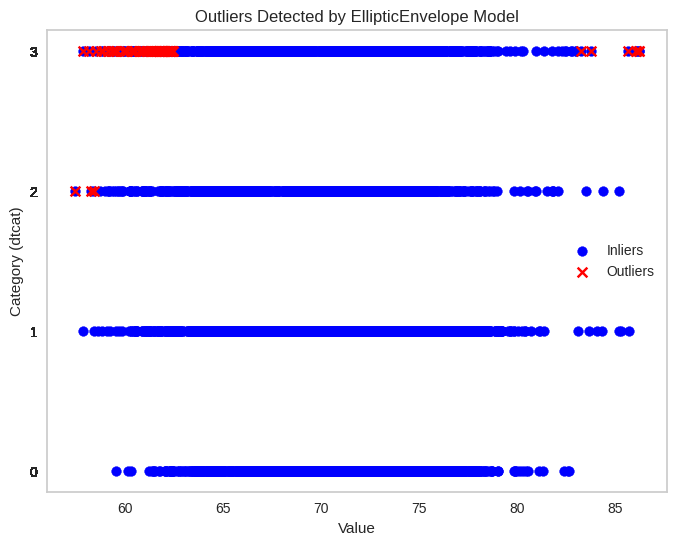

In [ ]:
#GD plot given 0.01 as outliers_fraction
plt.figure(figsize=(8, 6))
plt.scatter(data['value'], data['dtcat'], c='blue', marker='o', label='Inliers')
plt.scatter(gdoutliers['value'], gdoutliers['dtcat'], c='red', marker='x', label='Outliers')
plt.xlabel('Value')
plt.ylabel('Category (dtcat)')
plt.yticks(data['dtcat'])
plt.title('Outliers Detected by EllipticEnvelope Model')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
#GD model calcuated outliers_fraction
gdmodel1 = EllipticEnvelope(contamination=outliers_fraction1, random_state=42)
gdmodel1.fit(data)
gdmodel_pred1 = gdmodel1.predict(data)

gdoutliers1 = data[gdmodel_pred1 == -1]
count_outliers1 = gdoutliers1.shape[0]
print('The count of outliers is:', count_outliers1)

#outliers by dt category
outliers_by_category1 = gdoutliers1.groupby('dtcat').size().reset_index(name='count')
print(outliers_by_category1)

print(gdoutliers1)

The count of outliers is: 35
   dtcat  count
0      2      1
1      3     34
                         value  dtcat
timestamp                            
2013-12-22 19:00:00  86.094888      3
2013-12-22 20:00:00  86.204189      3
2013-12-22 21:00:00  86.223213      3
2013-12-22 22:00:00  85.649437      3
2013-12-22 23:00:00  86.074710      3
2014-04-12 20:00:00  60.330803      3
2014-04-12 21:00:00  61.318620      3
2014-04-12 22:00:00  61.265154      3
2014-04-12 23:00:00  59.564727      3
2014-04-13 00:00:00  59.921448      3
2014-04-13 01:00:00  60.093541      3
2014-04-13 02:00:00  59.922186      3
2014-04-13 03:00:00  58.862275      3
2014-04-13 04:00:00  58.777141      3
2014-04-13 05:00:00  59.410747      3
2014-04-13 06:00:00  57.844573      3
2014-04-13 09:00:00  57.458406      2
2014-04-13 19:00:00  59.375845      3
2014-04-13 20:00:00  60.450370      3
2014-04-13 21:00:00  60.383213      3
2014-04-13 22:00:00  59.910947      3
2014-04-13 23:00:00  60.283964      3
2014-04-20 

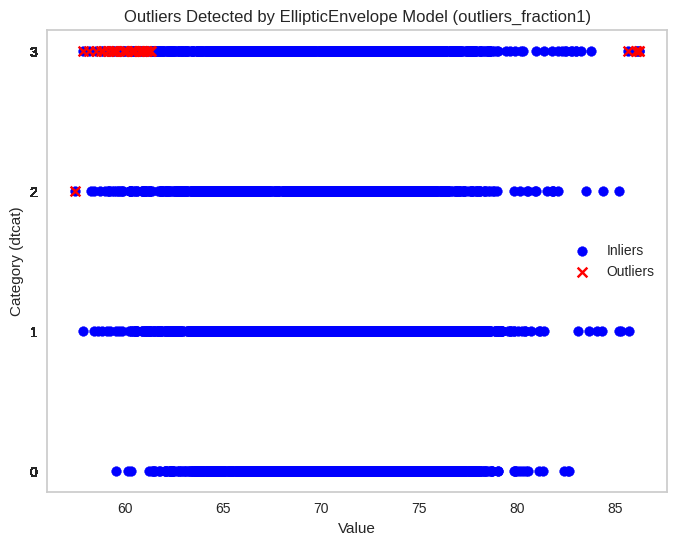

In [ ]:
#GD plot calcuated outliers_fraction
plt.figure(figsize=(8, 6))
plt.scatter(data['value'], data['dtcat'], c='blue', marker='o', label='Inliers')
plt.scatter(gdoutliers1['value'], gdoutliers1['dtcat'], c='red', marker='x', label='Outliers')
plt.xlabel('Value')
plt.ylabel('Category (dtcat)')
plt.yticks(data['dtcat'])
plt.title('Outliers Detected by EllipticEnvelope Model (outliers_fraction1)')
plt.legend()
plt.grid(False)
plt.show()



*   The Gaussian Distribution models predict outliers only in the Weekend Day (2)
and Weekend Night (3) categories.
*   The majority of outliers are in the Weekend Night category.
* This model aligns with temperature distribution by category, where Weekend Night had the largest temperature fluctuation or range.

# Isolation Forest

In [ ]:
#IF model given 0.01 as outliers_fraction
from sklearn.ensemble import IsolationForest

isfmodel = IsolationForest(contamination=outliers_fraction, random_state=42)
isfmodel.fit(data)
isfmodel_pred = isfmodel.predict(data)

isfoutliers = data[isfmodel_pred == -1]

count_outliers2 = isfoutliers.shape[0]
print('The count of outliers is:', count_outliers2)

#outliers by dt category
outliers_by_category2 = isfoutliers.groupby('dtcat').size().reset_index(name='count')
print(outliers_by_category2)

print(isfoutliers)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



The count of outliers is: 73
   dtcat  count
0      0     10
1      1     12
2      2     12
3      3     39
                         value  dtcat
timestamp                            
2013-12-21 19:00:00  79.896875      3
2013-12-21 20:00:00  82.289240      3
2013-12-21 21:00:00  82.989869      3
2013-12-21 22:00:00  83.247886      3
2013-12-21 23:00:00  82.519659      3
...                        ...    ...
2014-05-19 01:00:00  57.861906      1
2014-05-19 02:00:00  58.639295      1
2014-05-19 03:00:00  59.074691      1
2014-05-19 07:00:00  60.171092      0
2014-05-19 08:00:00  60.296682      0

[73 rows x 2 columns]


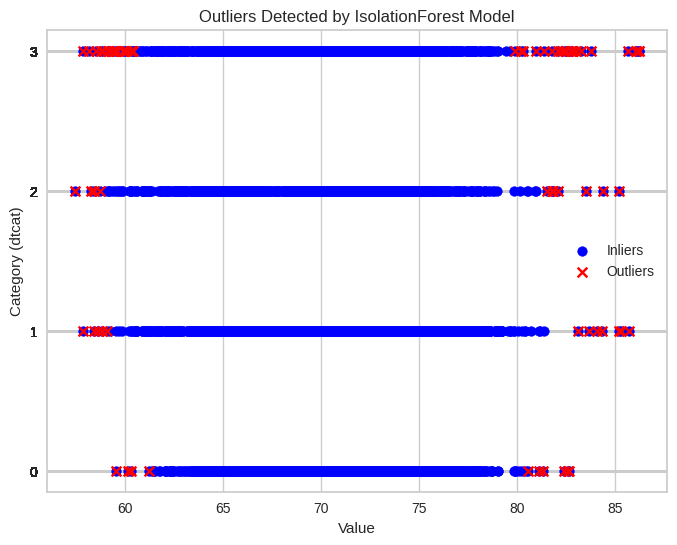

In [ ]:
#IF plot given 0.01 as outliers_fraction
plt.figure(figsize=(8, 6))
plt.scatter(data['value'], data['dtcat'], c='blue', marker='o', label='Inliers')
plt.scatter(isfoutliers['value'], isfoutliers['dtcat'], c='red', marker='x', label='Outliers')
plt.xlabel('Value')
plt.ylabel('Category (dtcat)')
plt.yticks(data['dtcat'])
plt.title('Outliers Detected by IsolationForest Model')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#IF model calcuated outliers_fraction
isfmodel1 = IsolationForest(contamination=outliers_fraction1, random_state=42)
isfmodel1.fit(data)
isfmodel_pred1 = isfmodel1.predict(data)

isfoutliers1 = data[isfmodel_pred1 == -1]

count_outliers3 = isfoutliers1.shape[0]
print('The count of outliers is:', count_outliers3)

#outliers by dt category
outliers_by_category3 = isfoutliers1.groupby('dtcat').size().reset_index(name='count')
print(outliers_by_category3)

print(isfoutliers1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



The count of outliers is: 35
   dtcat  count
0      0      6
1      2      2
2      3     27
                         value  dtcat
timestamp                            
2013-12-21 20:00:00  82.289240      3
2013-12-21 21:00:00  82.989869      3
2013-12-21 22:00:00  83.247886      3
2013-12-21 23:00:00  82.519659      3
2013-12-22 00:00:00  82.736802      3
2013-12-22 01:00:00  83.780995      3
2013-12-22 02:00:00  83.008634      3
2013-12-22 03:00:00  82.815627      3
2013-12-22 04:00:00  81.774744      3
2013-12-22 05:00:00  82.454278      3
2013-12-22 06:00:00  82.091901      3
2013-12-22 17:00:00  84.390932      2
2013-12-22 18:00:00  85.227685      2
2013-12-22 19:00:00  86.094888      3
2013-12-22 20:00:00  86.204189      3
2013-12-22 21:00:00  86.223213      3
2013-12-22 22:00:00  85.649437      3
2013-12-22 23:00:00  86.074710      3
2013-12-23 07:00:00  82.627288      0
2013-12-23 08:00:00  82.622298      0
2013-12-23 09:00:00  82.373437      0
2014-01-12 20:00:00  81.376188   

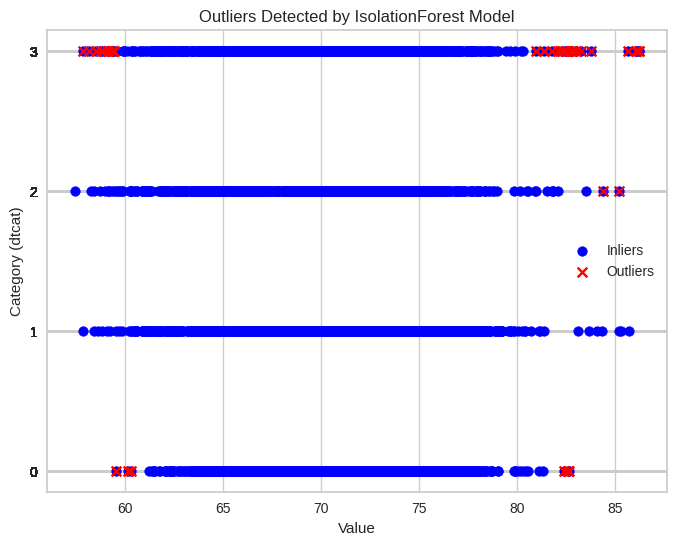

In [ ]:
#IF plot calcuated outliers_fraction
plt.figure(figsize=(8, 6))
plt.scatter(data['value'], data['dtcat'], c='blue', marker='o', label='Inliers')
plt.scatter(isfoutliers1['value'], isfoutliers1['dtcat'], c='red', marker='x', label='Outliers')
plt.xlabel('Value')
plt.ylabel('Category (dtcat)')
plt.yticks(data['dtcat'])
plt.title('Outliers Detected by IsolationForest Model')
plt.legend()
plt.grid(True)
plt.show()

* The Isolation Forest model shows outliers in all categories for the given outlier fraction.
* When using the calculated fraction, it identifies outliers in categories 0, 2, and 3.

The Gaussian Distribution model appears to be more focused on capturing outliers in specific categories with larger temperature variations, such as Weekend Night. On the other hand, the Isolation Forest model seems better at capturing general anomalies across all categories. Weekend Night (3) has the most detected outliers in both models.